### Import Programs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt

import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from pandas.core import datetools

from sklearn.preprocessing import LabelEncoder

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, average_precision_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  


### Import Dataset from Excel file

These are the files produced in the previous Python notebook that performed cleansing and initial feature reduction.

In [3]:
X = pd.read_csv('data/HID_features.csv', index_col=0)
df_clean = pd.read_csv('data/df_clean.csv', index_col=0)

### Make more balanced datasets for the label ('IS_HID')

This dataset has a very big imbalanced class problem for the label attribute ('IS_HID' = a flag for whether the pharmacy is a current contract pharmacy of Macro Helix).   

        Positive labeled observations     177
        Negative labeled observations   4,669

To address this, we undersampled the Negative class (picked a random 1,000 observations out of the 4,669 Negative observations) to make the training set more balanced.

In [4]:
X.columns

Index(['Auto_Ship_Ind', 'Interior_Decor_Signage_Available_Funds',
       'LMS_Enrolled', 'LMS_Available_Matching_Funds',
       'LMS_Used_Funds_Most_Recent_3_Months',
       'LMS_Used_Funds_Previous_3_Months', 'Open_Smart', 'PIP_Program',
       'PQS_Program', 'SCS_Program', 'Spar_Coverage_Ind',
       'Specialty_Solutions', 'Vaccine_Items', 'Vaccine_Starter',
       'Vaccine_Items_Count', 'Vaccine_Items_Sls_Amt', 'YPO', 'Tot_Sls_Amt',
       'DLC_Program_encoded', 'FEM_Program_encoded',
       'HM_Circular_Program_encoded', 'Internal_Decor', 'PQS_Enrolled_encoded',
       'ST_encoded', 'Pog_Code_Name_encoded', 'DC_Name_encoded',
       'Bus_Type_Desc_encoded', 'Region_encoded', 'PSAO_Expanded_encoded',
       'Chain_Name_encoded', 'Salesperson_encoded', 'AH_Program_encoded',
       'OTC_Front-end_Size_encoded', 'MRA_Program_Type_-_Active_AH_encoded',
       'Msa_Dma_encoded', 'Signage_Program_encoded',
       'Hospital_Associated_encoded'],
      dtype='object')

In [5]:
MH = df_clean.loc[df_clean['IS_HID'] == 1]

In [6]:
MH.head()

,Zip,Hm_Start_Dt,Channel_Type_Cd,Auto_Ship_Ind,Internal_Decor,Interior_Decor_Signage_Available_Funds,LMS_Enrolled,LMS_Available_Matching_Funds,LMS_Used_Funds_Most_Recent_3_Months,LMS_Used_Funds_Previous_3_Months,...,Chain_Name_encoded,Region_Name_encoded,Salesperson_encoded,AH_Program_encoded,OTC_Front-end_Size_encoded,MRA_Program_Type_-_Active_AH_encoded,Msa_Dma_encoded,Signage_Program_encoded,3rd_Party_Vendor_encoded,Hospital_Associated_encoded
Account,,,,,,,,,,,,,,,,,,,,,
410092,58503,732524,30,0,1,0.0,1,0.0,1,1,...,38,23,10,0,5,2,139,0,6,3
363318,66434,736441,30,0,0,2500.0,1,5800.0,0,0,...,33,27,31,0,6,0,85,1,6,0
304550,54409,732288,30,1,1,1829.0,0,1200.0,0,0,...,38,23,110,0,1,3,145,0,6,0
756418,58078,733881,30,0,1,603.0,1,700.0,1,1,...,39,23,10,0,3,2,153,5,6,3
410068,58504,732556,30,0,1,0.0,1,0.0,1,1,...,38,23,10,0,5,2,139,0,6,3


In [7]:
NonMH = df_clean.loc[df_clean['IS_HID'] == 0]

In [8]:
NonMH.head()

,Zip,Hm_Start_Dt,Channel_Type_Cd,Auto_Ship_Ind,Internal_Decor,Interior_Decor_Signage_Available_Funds,LMS_Enrolled,LMS_Available_Matching_Funds,LMS_Used_Funds_Most_Recent_3_Months,LMS_Used_Funds_Previous_3_Months,...,Chain_Name_encoded,Region_Name_encoded,Salesperson_encoded,AH_Program_encoded,OTC_Front-end_Size_encoded,MRA_Program_Type_-_Active_AH_encoded,Msa_Dma_encoded,Signage_Program_encoded,3rd_Party_Vendor_encoded,Hospital_Associated_encoded
Account,,,,,,,,,,,,,,,,,,,,,
10491,97463,732524,30,1,1,1724.0,1,822.0,1,1,...,39,23,1,4,1,7,183,0,18,15
17475,97630,732687,30,1,1,0.0,1,0.0,1,1,...,39,23,1,0,3,3,190,0,18,15
19901,97471,732616,30,0,1,0.0,1,0.0,1,1,...,39,23,1,0,4,2,183,0,18,15
309745,97467,735998,30,0,0,2500.0,1,0.0,0,0,...,39,23,1,0,1,8,183,3,18,15
652229,97370,734702,30,0,1,0.0,1,340.0,1,0,...,38,23,1,0,0,8,183,0,18,15


In [9]:
# Get a samller, random sample of Negative observations and add to Positive observations - to balance the classes

NonMHsample1 = NonMH.sample(n=1000)
dfsample1 = MH.append(NonMHsample1)

In [10]:
dfsample1.head()

,Zip,Hm_Start_Dt,Channel_Type_Cd,Auto_Ship_Ind,Internal_Decor,Interior_Decor_Signage_Available_Funds,LMS_Enrolled,LMS_Available_Matching_Funds,LMS_Used_Funds_Most_Recent_3_Months,LMS_Used_Funds_Previous_3_Months,...,Chain_Name_encoded,Region_Name_encoded,Salesperson_encoded,AH_Program_encoded,OTC_Front-end_Size_encoded,MRA_Program_Type_-_Active_AH_encoded,Msa_Dma_encoded,Signage_Program_encoded,3rd_Party_Vendor_encoded,Hospital_Associated_encoded
Account,,,,,,,,,,,,,,,,,,,,,
410092,58503,732524,30,0,1,0.0,1,0.0,1,1,...,38,23,10,0,5,2,139,0,6,3
363318,66434,736441,30,0,0,2500.0,1,5800.0,0,0,...,33,27,31,0,6,0,85,1,6,0
304550,54409,732288,30,1,1,1829.0,0,1200.0,0,0,...,38,23,110,0,1,3,145,0,6,0
756418,58078,733881,30,0,1,603.0,1,700.0,1,1,...,39,23,10,0,3,2,153,5,6,3
410068,58504,732556,30,0,1,0.0,1,0.0,1,1,...,38,23,10,0,5,2,139,0,6,3


In [11]:
X1 = dfsample1[['Auto_Ship_Ind', 'Interior_Decor_Signage_Available_Funds',
       'LMS_Enrolled', 'LMS_Available_Matching_Funds',
       'LMS_Used_Funds_Most_Recent_3_Months',
       'LMS_Used_Funds_Previous_3_Months', 'Open_Smart', 'PIP_Program',
       'PQS_Program', 'SCS_Program', 'Spar_Coverage_Ind',
       'Specialty_Solutions', 'Vaccine_Items', 'Vaccine_Starter',
       'Vaccine_Items_Count', 'Vaccine_Items_Sls_Amt', 'YPO', 'Tot_Sls_Amt',
       'DLC_Program_encoded', 'FEM_Program_encoded',
       'HM_Circular_Program_encoded', 'Internal_Decor', 'PQS_Enrolled_encoded',
       'ST_encoded', 'Pog_Code_Name_encoded', 'DC_Name_encoded',
       'Bus_Type_Desc_encoded', 'Region_encoded', 'PSAO_Expanded_encoded',
       'Chain_Name_encoded', 'Salesperson_encoded', 'AH_Program_encoded',
       'OTC_Front-end_Size_encoded', 'MRA_Program_Type_-_Active_AH_encoded',
       'Msa_Dma_encoded', 'Signage_Program_encoded',
       'Hospital_Associated_encoded']]

In [12]:
y = df_clean['IS_HID']

In [13]:
y_small = dfsample1['IS_HID']

### Try some models and look at performance metrics and important features

In [14]:
# Split the data into train-test

X_train, X_test, y_train, y_test = train_test_split(X1, y_small, test_size=0.33, random_state=42)

In [15]:
# Random Forest

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.feature_importances_
pred_rf = rf.predict(X_test) 
rf_score_r2 = np.mean(cross_val_score(rf, X_train, y_train, scoring='r2', cv=5))
rf_score_recall = recall_score(y_test, pred_rf, average='weighted')
rf_score_avgprecision = average_precision_score(y_test, pred_rf)

print("R2 Score cross-validated: ", rf_score_r2)
print("Recall Score: ", rf_score_recall)
print("Precision Score average:  ", rf_score_avgprecision)

R2 Score cross-validated:  0.347010046206
Recall Score:  0.938303341902
Precision Score average:   0.644188922799


The most important measure for this business problem is Recall.  This is because Recall captures how many actual Positives the model finds.  In other words, does the model correctly predict current contract pharmacies of Macro Helix?   We want a model that can recognize an actual contract pharmacy.  Precision is not as important, as this captures how many the model labels as positive, compared to how many of those actually are positive; since we know that most of the pharmacies are not currently contract pharmacies, this measure is not very useful to the problem.  Similarly, Accuracy/R2 is not as important because since most in the dataset are negative, the model could merely predict all are negative and have a great Accuracy/R2 score -- not very meaningful.

In [16]:
feature_imp_rf = pd.DataFrame({'Feature Importance' : rf.feature_importances_}, index=X1.columns)
print(feature_imp_rf)

                                        Feature Importance
Auto_Ship_Ind                                     0.007137
Interior_Decor_Signage_Available_Funds            0.022950
LMS_Enrolled                                      0.003508
LMS_Available_Matching_Funds                      0.030916
LMS_Used_Funds_Most_Recent_3_Months               0.007339
LMS_Used_Funds_Previous_3_Months                  0.001018
Open_Smart                                        0.000000
PIP_Program                                       0.012333
PQS_Program                                       0.004001
SCS_Program                                       0.006941
Spar_Coverage_Ind                                 0.007146
Specialty_Solutions                               0.000000
Vaccine_Items                                     0.001771
Vaccine_Starter                                   0.001541
Vaccine_Items_Count                               0.013998
Vaccine_Items_Sls_Amt                             0.0112

In [17]:
# Decision Tree

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.feature_importances_
pred_dt = dt.predict(X_test) 
dt_score_r2 = np.mean(cross_val_score(dt, X_train, y_train, scoring='r2', cv=5))
dt_score_recall = recall_score(y_test, pred_dt, average='weighted')
dt_score_avgprecision = average_precision_score(y_test, pred_dt)

print("R2 Score cross-validated: ", dt_score_r2)
print("Recall Score: ", dt_score_recall)
print("Precision Score average:  ", dt_score_avgprecision)

R2 Score cross-validated:  0.445642293599
Recall Score:  0.910025706941
Precision Score average:   0.544581210435


In [18]:
feature_imp_dt = pd.DataFrame({'Feature Importance' : dt.feature_importances_}, index=X1.columns)
print(feature_imp_dt)

                                        Feature Importance
Auto_Ship_Ind                                     0.006964
Interior_Decor_Signage_Available_Funds            0.000000
LMS_Enrolled                                      0.009073
LMS_Available_Matching_Funds                      0.016505
LMS_Used_Funds_Most_Recent_3_Months               0.000000
LMS_Used_Funds_Previous_3_Months                  0.000000
Open_Smart                                        0.000000
PIP_Program                                       0.000000
PQS_Program                                       0.008998
SCS_Program                                       0.004949
Spar_Coverage_Ind                                 0.000000
Specialty_Solutions                               0.000000
Vaccine_Items                                     0.000000
Vaccine_Starter                                   0.008508
Vaccine_Items_Count                               0.014039
Vaccine_Items_Sls_Amt                             0.0156

In [19]:
# Gradient Boosting

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb.feature_importances_
pred_gb = gb.predict(X_test) 
gb_score_r2 = np.mean(cross_val_score(gb, X_train, y_train, scoring='r2', cv=5))
gb_score_recall = recall_score(y_test, pred_gb, average='weighted')
gb_score_avgprecision = average_precision_score(y_test, pred_gb)

print("R2 Score cross-validated: ", gb_score_r2)
print("Recall Score: ", gb_score_recall)
print("Precision Score average:  ", gb_score_avgprecision)

R2 Score cross-validated:  0.525743422476
Recall Score:  0.953727506427
Precision Score average:   0.736869897203


In [20]:
feature_imp_gb = pd.DataFrame({'Feature Importance' : gb.feature_importances_}, index=X1.columns)
print(feature_imp_gb)

                                        Feature Importance
Auto_Ship_Ind                                 0.000000e+00
Interior_Decor_Signage_Available_Funds        2.029888e-02
LMS_Enrolled                                  0.000000e+00
LMS_Available_Matching_Funds                  4.809607e-02
LMS_Used_Funds_Most_Recent_3_Months           7.708426e-04
LMS_Used_Funds_Previous_3_Months              2.950323e-03
Open_Smart                                    0.000000e+00
PIP_Program                                   1.681809e-03
PQS_Program                                   2.148140e-03
SCS_Program                                   1.012551e-02
Spar_Coverage_Ind                             0.000000e+00
Specialty_Solutions                           0.000000e+00
Vaccine_Items                                 1.560072e-03
Vaccine_Starter                               1.628153e-03
Vaccine_Items_Count                           2.056417e-02
Vaccine_Items_Sls_Amt                         1.504695e-

In [21]:
# show which features are most important

def plot_feature_importance(model, df):
    cols = []
    for col in df.columns:
        cols.append(col)

    feature_importances = pd.DataFrame({'Feature Importance' : model.feature_importances_}, index=cols)
    feature_importances = feature_importances.sort_values(by='Feature Importance')
    feature_importances.plot(kind='barh', color='r', figsize=(6,6))
    plt.title('Feature Importance', fontsize=18)
    plt.tight_layout()
    plt.savefig('figures/feat_import.png', dpi=300)

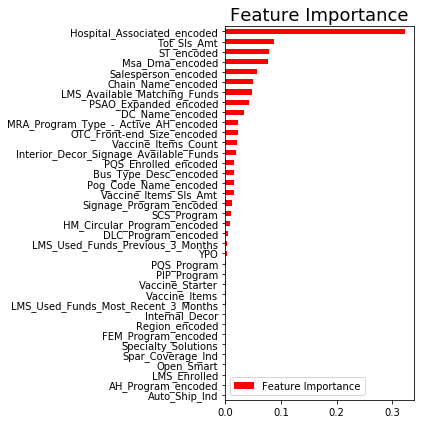

In [22]:
plot_feature_importance(gb, X_test)

### Reduce the dimensions even further, based on Feature Importance

Pick the top features to model, making the model simpler but still performing as well.

In [23]:
XR = dfsample1[['Hospital_Associated_encoded', 'Tot_Sls_Amt', 'Msa_Dma_encoded',
                'Salesperson_encoded', 'ST_encoded',
                'Chain_Name_encoded','LMS_Available_Matching_Funds']]

In [24]:
XR_train = X_train[['Hospital_Associated_encoded', 'Tot_Sls_Amt', 'Msa_Dma_encoded',
                'Salesperson_encoded', 'ST_encoded',
                'Chain_Name_encoded','LMS_Available_Matching_Funds']]

XR_test = X_test[['Hospital_Associated_encoded', 'Tot_Sls_Amt', 'Msa_Dma_encoded',
                'Salesperson_encoded', 'ST_encoded',
                'Chain_Name_encoded','LMS_Available_Matching_Funds']]

In [25]:
# Gradient Boosting with reduced features

gbr = GradientBoostingClassifier()
gbr.fit(XR_train, y_train)
gbr.feature_importances_
pred_gbr = gbr.predict(XR_test) 
gbr_score_r2 = np.mean(cross_val_score(gbr, XR_train, y_train, scoring='r2', cv=5))
gbr_score_recall = recall_score(y_test, pred_gbr, average='weighted')
gbr_score_avgprecision = average_precision_score(y_test, pred_gbr)

print("R2 Score cross-validated: ", gbr_score_r2)
print("Recall Score: ", gbr_score_recall)
print("Precision Score average:  ", gbr_score_avgprecision)

R2 Score cross-validated:  0.435816422952
Recall Score:  0.943444730077
Precision Score average:   0.687775906391


In [26]:
feature_imp_gbr = pd.DataFrame({'Feature Importance' : gbr.feature_importances_}, index=XR.columns)
print(feature_imp_gbr)

                              Feature Importance
Hospital_Associated_encoded             0.355239
Tot_Sls_Amt                             0.199136
Msa_Dma_encoded                         0.075563
Salesperson_encoded                     0.127564
ST_encoded                              0.068744
Chain_Name_encoded                      0.097679
LMS_Available_Matching_Funds            0.076076


Save processed data to files for review

In [27]:
X.to_csv('data/HID_all_obs.csv')
X1.to_csv('data/HID_undersampled_obs.csv')
XR.to_csv('data/HID_reduced_features.csv')
dfsample1.to_csv('data/HID_undersampled_w_label.csv')

### GridSearch to optimize the model, using the reduced feature set

How can we optimized the model that seems to perform the best?   We try many parameters via GridSearch.

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
gbr_params = dict(learning_rate=np.arange(0.1, 0.5, 0.1),
                        min_samples_split=np.arange(2,5,1),
                        max_depth=np.arange(1, 7, 1),
                        max_features=np.array([1, 2, 3, 4, 5, 6, 7, None, 'auto', 'sqrt', 'log2']),
                        n_estimators=np.arange(60, 140, 10))

In [30]:
gs_gbr = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=gbr_params)

In [31]:
gs_gbr.fit(XR_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([ 0.1,  0.2,  0.3,  0.4]), 'min_samples_split': array([2, 3, 4]), 'max_depth': array([1, 2, 3, 4, 5, 6]), 'max_features': array([1, 2, 3, 4, 5, 6, 7, None, 'auto', 'sqrt', 'log2'], dtype=object), 'n_estimators': array([ 60,  70,  80,  90, 100, 110, 120, 130])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
gs_gbr.best_params_

{'learning_rate': 0.40000000000000002,
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_split': 3,
 'n_estimators': 70}

In [33]:
gs_gbr.best_score_

0.95177664974619292

In [34]:
gs_gbr.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.40000000000000002, loss='deviance',
              max_depth=3, max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [40]:
best_model = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.40000000000000002, loss='deviance',
              max_depth=3, max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
best_model.fit(XR_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.4, loss='deviance', max_depth=3,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [41]:
best_model.feature_importances_
pred_best_model = best_model.predict(XR_test) 
best_model_score_r2 = np.mean(cross_val_score(best_model, XR_train, y_train, scoring='r2', cv=5))
best_model_score_recall = recall_score(y_test, pred_best_model, average='weighted')
best_model_score_avgprecision = average_precision_score(y_test, pred_best_model)

print("R2 Score cross-validated: ", best_model_score_r2)
print("Recall Score: ", best_model_score_recall)
print("Precision Score average:  ", best_model_score_avgprecision)

R2 Score cross-validated:  0.466414657669
Recall Score:  0.951156812339
Precision Score average:   0.722621641419


### Run the model (reduced feature set) on ALL observations

We trained and fitted the model with a reduced set of observations (to address the class imbalance for the label), so now we want to try the model on all observations, to learn which pharmacies it predicts as contract pharmacies for Macro Helix.

In [42]:
XR_all_obs = X[['Hospital_Associated_encoded', 'Tot_Sls_Amt', 'Msa_Dma_encoded',
                'Salesperson_encoded', 'ST_encoded',
                'Chain_Name_encoded','LMS_Available_Matching_Funds']]    

In [43]:
pred_best_model_all_obs = best_model.predict(XR_all_obs)

In [44]:
best_model_all_obs_score_acc = np.mean(cross_val_score(best_model, XR_all_obs, y, cv=5))
best_model_all_obs_score_recall = recall_score(y, pred_best_model_all_obs, average='weighted') 
best_model_all_obs_score_avgprecision = average_precision_score(y, pred_best_model_all_obs)

print("Accuracy Score cross-validated: ", best_model_all_obs_score_acc)
print("Recall Score: ", best_model_all_obs_score_recall)
print("Precision Score average:  ", best_model_all_obs_score_avgprecision)

Accuracy Score cross-validated:  0.953157554901
Recall Score:  0.969046636401
Precision Score average:   0.515304507904


Recall score is improved and is AWESOME!

### Put Actual HID and Predicted HID into final dataset

In [45]:
df_clean['Actual_HID'] = df_clean['IS_HID'] 

In [46]:
df_clean['Predicted_HID'] = pred_best_model_all_obs                

In [47]:
df_clean.head()

,Zip,Hm_Start_Dt,Channel_Type_Cd,Auto_Ship_Ind,Internal_Decor,Interior_Decor_Signage_Available_Funds,LMS_Enrolled,LMS_Available_Matching_Funds,LMS_Used_Funds_Most_Recent_3_Months,LMS_Used_Funds_Previous_3_Months,...,Salesperson_encoded,AH_Program_encoded,OTC_Front-end_Size_encoded,MRA_Program_Type_-_Active_AH_encoded,Msa_Dma_encoded,Signage_Program_encoded,3rd_Party_Vendor_encoded,Hospital_Associated_encoded,Actual_HID,Predicted_HID
Account,,,,,,,,,,,,,,,,,,,,,
10491,97463,732524,30,1,1,1724.0,1,822.0,1,1,...,1,4,1,7,183,0,18,15,0,0
17475,97630,732687,30,1,1,0.0,1,0.0,1,1,...,1,0,3,3,190,0,18,15,0,0
19901,97471,732616,30,0,1,0.0,1,0.0,1,1,...,1,0,4,2,183,0,18,15,0,0
309745,97467,735998,30,0,0,2500.0,1,0.0,0,0,...,1,0,1,8,183,3,18,15,0,0
652229,97370,734702,30,0,1,0.0,1,340.0,1,0,...,1,0,0,8,183,0,18,15,0,0


Save to file for the business to review predicted contract pharmacies.

In [48]:
df_clean.to_csv('data/HID_predictions.csv')